## Project Description

The *Clean Taxi* company has collected historical data on taxi orders at airports. To attract more drivers during peak periods, you need to predict the number of taxi orders for the next hour. Build a model for this prediction.

The value of the `RMSE` metric on the test sample must be under `48`.

### Data Description

The data is in the file `taxi.csv`. The number of orders is in the '*num_orders*' column.

### Content <a id='content'></a>

[**1. Data preprocessing**](#step1)

[**2. Data analytics**](#step2)
   
[**3. Train the model**](#step3)
   * [*3.1 Model 0 - random model*](#step3.1)
   * [*3.2 Model 1 - Linear Regression*](#step3.2)
   * [*3.3 Model 2 - RandomForestRegressor*](#step3.3)
   * [*3.4 Model 3 - LGBMRegressor*](#step3.4)

[**4. Test model performance**](#step4)

# 1. Data preprocessing   <a class="anchor" id="step1"></a>
[back to content](#content)

Import libraries:

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

random_state = 666

Load the data and make a column with dates and set it as index:

In [3]:
df = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [4]:
df.shape

(26496, 1)

Let's see some random rows in the dataset:

In [5]:
df.sample(5)

,num_orders
datetime,
2018-07-09 04:30:00,9
2018-08-28 12:20:00,36
2018-07-30 11:20:00,10
2018-04-16 07:20:00,0
2018-03-04 23:30:00,14


Let's check for missing values:

In [6]:
df.isnull().sum()

num_orders    0
dtype: int64

There are no missing values.

Let's create some functions for further work:

In [8]:
def plot_lineplot(data, title, xlabel, ylabel, legend=False, figsize=None):
    '''plot a simple line diagramm'''
    data.plot(title=title, legend=legend, figsize=figsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)  


def cross_validation(model, features, target, cv):
    '''test model on cross validation'''
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    result = cross_validate(model, features, target, scoring=mse_scorer, cv=cv)
    
    avg_test_score = np.abs(np.mean(result['test_score']))
    
    return np.round((avg_test_score ** 0.5), 2)


def find_best_hyperparams(features, target, model, param_grid,
                          cv=5, scoring='neg_mean_squared_error'):
    '''use GridSearchCV to find best model hyperparameters. Returns GS result object.'''
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring,
        verbose=2)
    
    result = gs.fit(features, target)
    
    return result


def make_features(data, target_col, max_lag, rolling_mean_size):
    '''create new features in dataset and return a copy of it'''
    data_copy = data.copy()
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    data_copy['rolling_mean'] = data_copy[target_col].shift().rolling(rolling_mean_size).mean()
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy[target_col].shift(lag)
    
    return data_copy


def calc_rmse(real, predict):
    '''calculate RMSE for selected estimator'''
    return np.round((mean_squared_error(real,predict) ** 0.5), 2)

Let's sort the data in chronological order:

In [9]:
df = df.sort_index()

Let's resample for one hour:

In [10]:
df = df.resample('1H').sum()

Let's see the result:

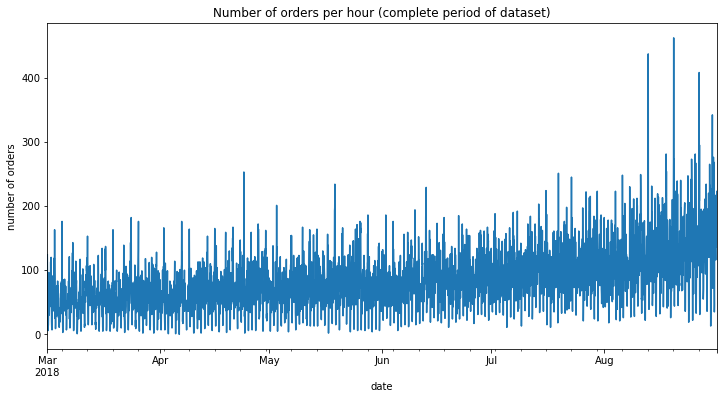

In [42]:
plot_lineplot(df, 'Number of orders per hour (complete period of dataset)',
              'date', 'number of orders', figsize=(12,6))

# 2. Data analytics   <a class="anchor" id="step2"></a>
[back to content](#content)

Let's analyze the time series by decomposing them using the `seasonal_decompose()` function into components: seasonality, trend and residuals.

In [21]:
df_decompose = seasonal_decompose(df, model='additive')

<AxesSubplot:xlabel='datetime'>

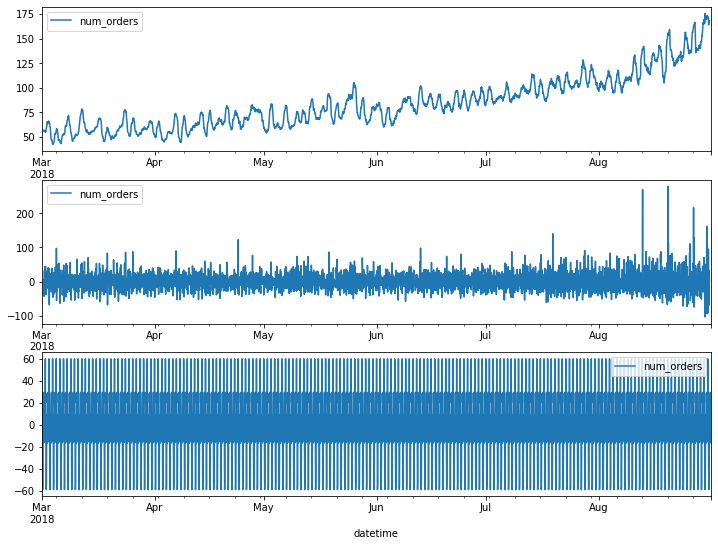

In [43]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,9))
df_decompose.trend.plot(ax=ax1)
df_decompose.resid.plot(ax=ax2)
df_decompose.seasonal.plot(ax=ax3)

There is a positive trend since June: the number of orders is growing. The average value changes over time, which means the series is non-stationary, at least since the summer season. In the seasonality graph, nothing is clear, you need to look at a narrower time period. Significant peaks in the remains are also found in the summer period.

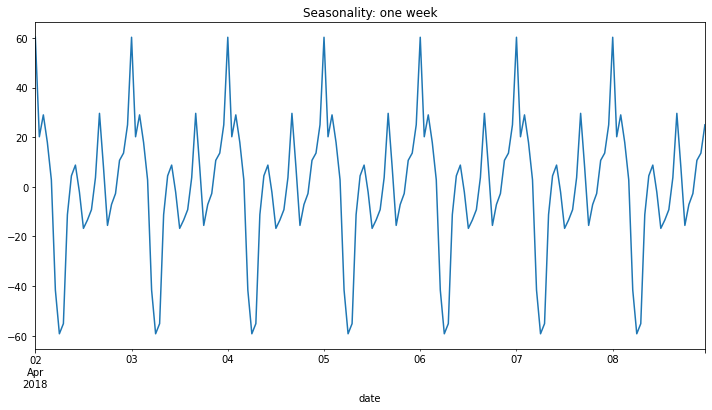

In [44]:
plot_lineplot(df_decompose.seasonal['2018-04-02':'2018-04-08'],
              'Seasonality: one week', 'date', '', figsize=(12,6))

The cyclical nature of the day is visible: the peak in the number of orders at night and least of all in the morning. Let's see the seasonality during the day to check:

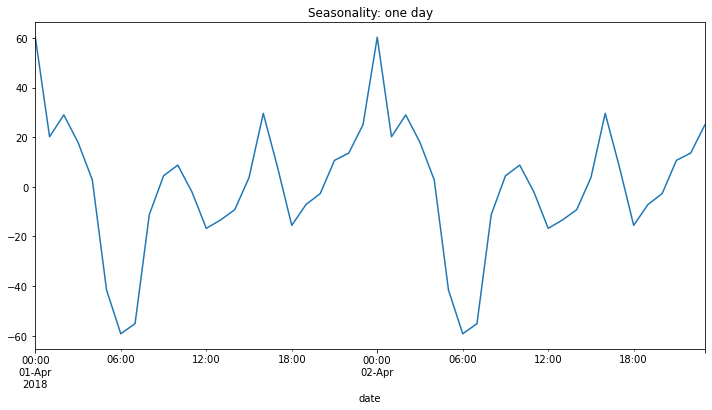

In [45]:
plot_lineplot(df_decompose.seasonal['2018-04-01':'2018-04-02'],
              'Seasonality: one day', 'date', '', figsize=(12,6))

# 3. Train the model   <a class="anchor" id="step3"></a>
[back to content](#content)

Let's create additional features in the data for training the model. Based on the seasonality schedule, it makes sense to add the hour and day of the week of the order. We will also add a moving average and lagging values.

In [46]:
df_features = make_features(df, 'num_orders', 24, 5)

Let's remove the resulting missing values:

In [47]:
df_features = df_features.dropna()

Let's divide the data into training and test samples:

In [48]:
train, test = train_test_split(df_features, shuffle=False, test_size=0.1)

Let's look at the split:

In [49]:
print('Train data from {} to {}'.format(train.index.min(), train.index.max()))
print('Test data from {} to {}'.format(test.index.min(), test.index.max()))

Train data from 2018-03-02 00:00:00 to 2018-08-13 15:00:00
Test data from 2018-08-13 16:00:00 to 2018-08-31 23:00:00


In [50]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)
target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [51]:
#the time series separator that will be passed to the cross-validation function
tscv = TimeSeriesSplit(n_splits=5)

PS: cells where the code takes a long time to execute (GridSearchCV for example) are converted to RAW format with the content of the output, so as not to wait every time for the end of the code, and some variables are set manually.

## 3. 1 Random model  <a class="anchor" id="step3.1"></a>
[back to content](#content)

First, let's try to predict the number of taxi orders by the median and the previous value.

In [52]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_previous = calc_rmse(test['num_orders'], pred_previous['num_orders'])
print('RMSE (previous value): {}'.format(rmse_previous))

RMSE (previous value): 58.88


In [53]:
pred_median = np.ones(test['num_orders'].shape) * train['num_orders'].median()
rmse_median = calc_rmse(test['num_orders'], pred_median)
print('RMSE (median value): {}'.format(rmse_median))

RMSE (median value): 87.21


The prediction by the previous value already shows a good result.

## 3. 2 Linear regression <a class="anchor" id="step3.2"></a>
[back to content](#content)

In [54]:
model_reg = LinearRegression().fit(features_train, target_train)

In [55]:
rmse_reg_cv = cross_validation(model_reg, features_train, target_train, tscv)
print('RMSE on cross validation (linear regression): {}'.format(rmse_reg_cv))

RMSE on cross validation (linear regression): 27.37


The metric is already significantly better than the constant model.

## 3.3 RadnomForestRegressor <a class="anchor" id="step3.3"></a>
[back to content](#content)

In [56]:
model_forest = RandomForestRegressor(random_state=random_state)

In [57]:
#set the range of hyperparameters from which we will seek the optimal
max_depth = [3, 5, 10, 12, 15]
n_estimators = [100, 200, 400]
param_forest  = {'max_depth': max_depth,
                 'n_estimators': n_estimators}

In [58]:
%%time
model_forest = RandomForestRegressor(max_depth=15,
                                     n_estimators=100,
                                     random_state=random_state).fit(features_train,
                                                                    target_train)

CPU times: user 4.17 s, sys: 6.88 ms, total: 4.18 s
Wall time: 4.19 s


In [59]:
rmse_forest_cv = 25.48
print('RMSE on cross validation (Random Forest Regressor): {}'.format(rmse_forest_cv))

RMSE on cross validation (Random Forest Regressor): 25.48


RMSE has improved slightly on random forest.

## 3.4 LGBMRegressor <a class="anchor" id="step3.4"></a>
[back to content](#content)

In [60]:
#create the model and set the range of hyperparameters
#from which we will seek the optimal
model_lgbm = lgb.LGBMRegressor(random_state=random_state)

lgbm_param_grid = {'n_estimators': [100, 200, 400],
                   'max_depth': [5, 10, 15],
                   'num_leaves': [30, 50, 100]
                  }

In [61]:
rmse_lgbm_cv = 24.96
print('RMSE on cross validation (LGBMRegressor): {}'.format(rmse_lgbm_cv))

RMSE on cross validation (LGBMRegressor): 24.96


In [62]:
%%time
#train the model with optimal hyperparameters
model_lgbm = lgb.LGBMRegressor(
    max_depth=5, num_leaves=50,
    n_estimators=100, random_state=random_state).fit(features_train, target_train)

CPU times: user 344 ms, sys: 7.9 ms, total: 352 ms
Wall time: 110 ms


LGBM has the same prediction quality as a random forest, but better performance.

# 4. Test model performance   <a class="anchor" id="step4"></a>
[back to content](#content)

Let's see how the models will work on the test sample.

In [63]:
#calculate the RMSE for each model on the test and save it into variables
reg_rmse_test = calc_rmse(test['num_orders'], model_reg.predict(features_test))
forest_rmse_test = calc_rmse(test['num_orders'], model_forest.predict(features_test))
lgbm_rmse_test = calc_rmse(test['num_orders'], model_lgbm.predict(features_test))

In [64]:
#create resulting table
result_table = pd.DataFrame({'Model': ['median value prediction',
                                       'previous value prediction',
                                       'Linear Regression',
                                       'Random Forest Regressor',
                                       'LGBMRegressor'],
                             'RMSE on test data': [rmse_median,
                                                   rmse_previous,
                                                   reg_rmse_test,
                                                   forest_rmse_test,
                                                   lgbm_rmse_test]})

Let's compare the models with each other:

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'median value prediction'),
  Text(1, 0, 'previous value prediction'),
  Text(2, 0, 'Linear Regression'),
  Text(3, 0, 'Random Forest Regressor'),
  Text(4, 0, 'LGBMRegressor')])

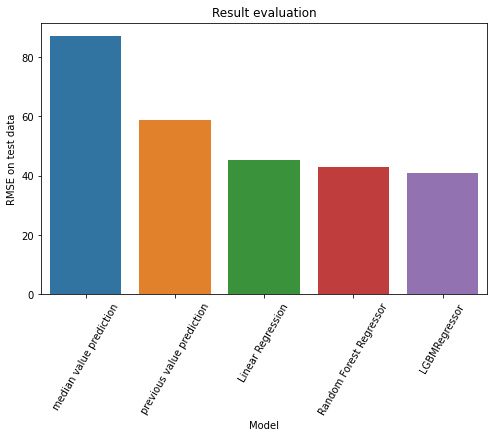

In [70]:
plt.figure(figsize=(8,5))
plt.title('Result evaluation')
sns.barplot(data=result_table, x='Model', y='RMSE on test data')
plt.xticks(rotation=60)

The best result was shown by LGBMRegressor by a small margin from linear regression and random forest. Median and previous predictions are noticeably worse.

Now let's compare the predictions of the best model with the real values of the target feature on test data.

In [71]:
#store the true values and predictions of the best model in one table
true_pred_compare = pd.DataFrame({'Real': test['num_orders'],
                                  'Prediction': model_lgbm.predict(features_test)})

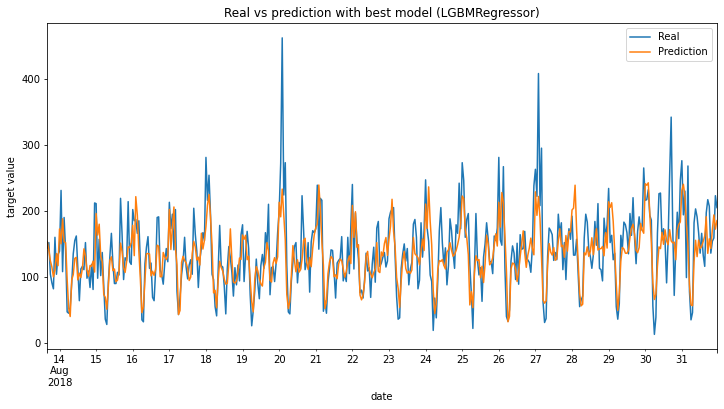

In [72]:
plot_lineplot(true_pred_compare,
              'Real vs prediction with best model (LGBMRegressor)',
              'date', 'target value',
              legend=True, figsize=(12,6))

As we can see in general the model copes well with the task. The best results are shown on  predictions of of the minimum order quantity peaks, since their average hardly changes. At abnormally high values, the model performed worse, since this is already a non-stationary case.

### Summary

* the best model `LGBMRegressor` showed `RMSE` value of `41`, reaching the metric goal
* in general, all tested models showed similar results
* to achieve a good quality of predictions, you need to choose the right additional features for the data
* in general, the time series from the dataset was not stationary. Perhaps with data over several years, it would be better to predict some peaks.